# i) GPU LightGBM Baseline 
In this notebook, we present a GPU LightGBM baseline. In this notebook, compared to my previous starter notebooks we teach 5 new things:
* How to tranform `efs` and `efs_time` into single target with `KaplanMeierFitter`.
* How to train `GPU LightGBM model` with `KaplanMeierFitter` target
* How to train `XGBoost with Survivial:Cox loss`
* How to train `CatBoost with Survival:Cox loss`
* How to ensemble 5 models using `scipy.stats.rankdata()`.

# ii) Two Competition Approaches
In this competition, there are two ways to train a Survival Model:
* We can input both `efs` and `efs_time` and train a **model that supports** `survival loss like Cox`.
* Transform `efs` and `efs_time` into a single target proxy for `risk score` and train **any model** with `regression loss like MSE`.

In this notebook, we train 5 models. The first 3 models (XGBoost, CatBoost, LightGBM) use bullet point two. And the next 2 models (XGBoost Cox, CatBoost Cox) use bullet point one. Discussion about this notebook is [here][4] and [here][3]. 

Since this competition's metric is a ranking metric, we ensemble the 5 predictions by first converting each into ranks using `scipy.stats.rankdata()`. Afterward we created a weighted average from the ranks.

Have Fun! Enjoy!

# iii) Previous Notebooks
My previous starter notebooks are:
<!-- * XGBoost and CatBoost starter [here][1]
* NN (MLP) starter [here][2] -->

Associated discussions are [here][3], [here][4], [here][5]!

[1]: https://www.kaggle.com/code/cdeotte/xgboost-catboost-baseline-cv-668-lb-668
[2]: https://www.kaggle.com/code/cdeotte/nn-mlp-baseline-cv-670-lb-676
[3]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550003
[4]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550141
[5]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550343

# iv) Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from my other notebook [here][1] where I downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

In [1]:
# Trick Copied From Chris Deotte
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=990234d6fc7975fd2a106d89ab15e10a7414a52c000e81031b007c70e70b8d5c
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# 0. Setting Up The Env.

## 0.1 The Packages

In [2]:
import numpy as np
import pandas as pd

In [3]:
from lifelines import KaplanMeierFitter
from sklearn.model_selection import StratifiedKFold, KFold

from metric import score

In [4]:

from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

from catboost import CatBoostRegressor, CatBoostClassifier
import catboost as cb

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

## 0.2 UDFs

In [6]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# 1. The Data

In [8]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


## 1.1 EDA Targets
There are two train targets `efs` and `efs_time`. When `efs==1` we know patient **had an event** and we know time of event is `efs_time`. When `efs==0` we **do not know** if patient had an event or not, but we do know that patient was **without event for at least** `efs_time`.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


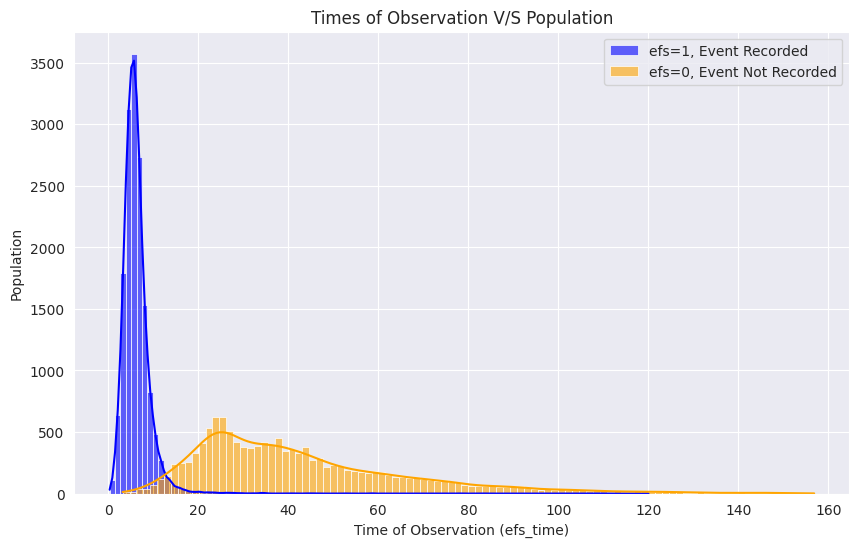

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train.loc[train.efs == 1, "efs_time"], bins=100, label="efs=1, Event Recorded", color="blue", kde=True, alpha=0.6)
sns.histplot(train.loc[train.efs == 0, "efs_time"], bins=100, label="efs=0, Event Not Recorded", color="orange", kde=True, alpha=0.6)

plt.xlabel("Time of Observation (efs_time)")
plt.ylabel("Population")
plt.title("Times of Observation V/S Population")
plt.legend()
plt.show()

## 1.2 Transform Targets: Two into One
Both targets `efs` and `efs_time` provide useful information. We will tranform these two targets into a single target to train our model with. In this competition we need to predict `risk score`. So we will create a target that mimics `risk score` to train our model. (Note this is only one out of many ways to transform two targets into one target. Considering experimenting on your own).

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


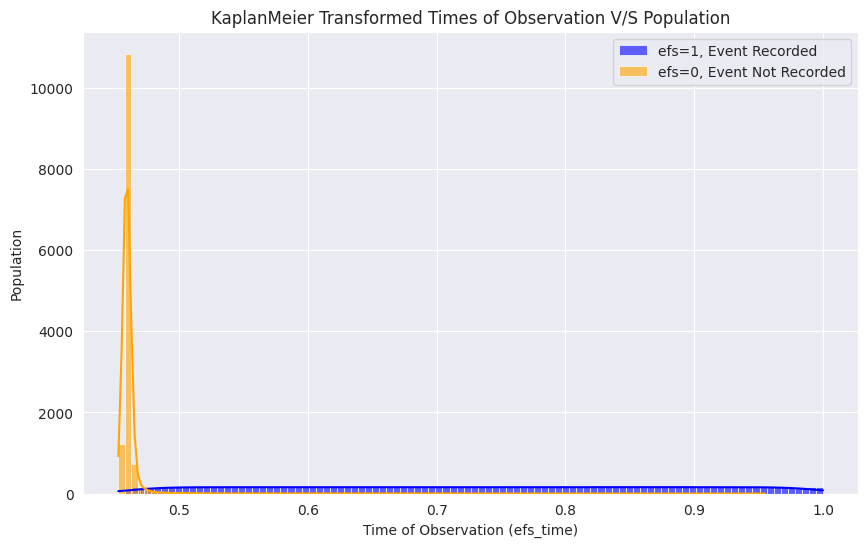

In [10]:
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')


plt.figure(figsize=(10, 6))
sns.histplot(train.loc[train.efs == 1, "y"], bins=100, label="efs=1, Event Recorded", color="blue", kde=True, alpha=0.6)
sns.histplot(train.loc[train.efs == 0, "y"], bins=100, label="efs=0, Event Not Recorded", color="orange", kde=True, alpha=0.6)

plt.xlabel("Time of Observation (efs_time)")
plt.ylabel("Population")
plt.title("KaplanMeier Transformed Times of Observation V/S Population")
plt.legend()
plt.show()

## 1.3 Features
There are a total of 57 features. From these 35 are categorical and 22 are numerical. We will label encode the categorical features. Then our XGB and CAT model will accept these as categorical features and process them special internally. We leave the numerical feature NANs as NANs because GBDT (like XGB and CAT) can handle NAN and will use this information.

In [11]:
xtra = ["ID","efs","efs_time","y"]
features = [c for c in train.columns if not c in xtra]
print(f"There are {len(features)} FEATURES: {features}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [12]:
CATS = []
for c in features:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [13]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("Label Encoded Categorical Features: ",end="")
for c in features:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

Label Encoded Categorical Features: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

# 2. XGBoost with KaplanMeier

In [14]:
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.0.3


In [15]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,features].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,features].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[features].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        early_stopping_rounds=7,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17562
[500]	validation_0-rmse:0.15761
[1000]	validation_0-rmse:0.15572
[1224]	validation_0-rmse:0.15532
#########################
### Fold 2
#########################


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:08:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:0.17825
[500]	validation_0-rmse:0.15917
[1000]	validation_0-rmse:0.15721
[1135]	validation_0-rmse:0.15697
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17557
[500]	validation_0-rmse:0.15830
[1000]	validation_0-rmse:0.15656
[1122]	validation_0-rmse:0.15631
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17652
[500]	validation_0-rmse:0.15968
[1000]	validation_0-rmse:0.15788
[1360]	validation_0-rmse:0.15735
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17588
[500]	validation_0-rmse:0.15928
[874]	validation_0-rmse:0.15792
CPU times: user 22.9 s, sys: 342 ms, total: 23.3 s
Wall time: 19.9 s


## 2.1 Score

In [16]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost KaplanMeier = 0.6704438130112683


## 2.2 Features

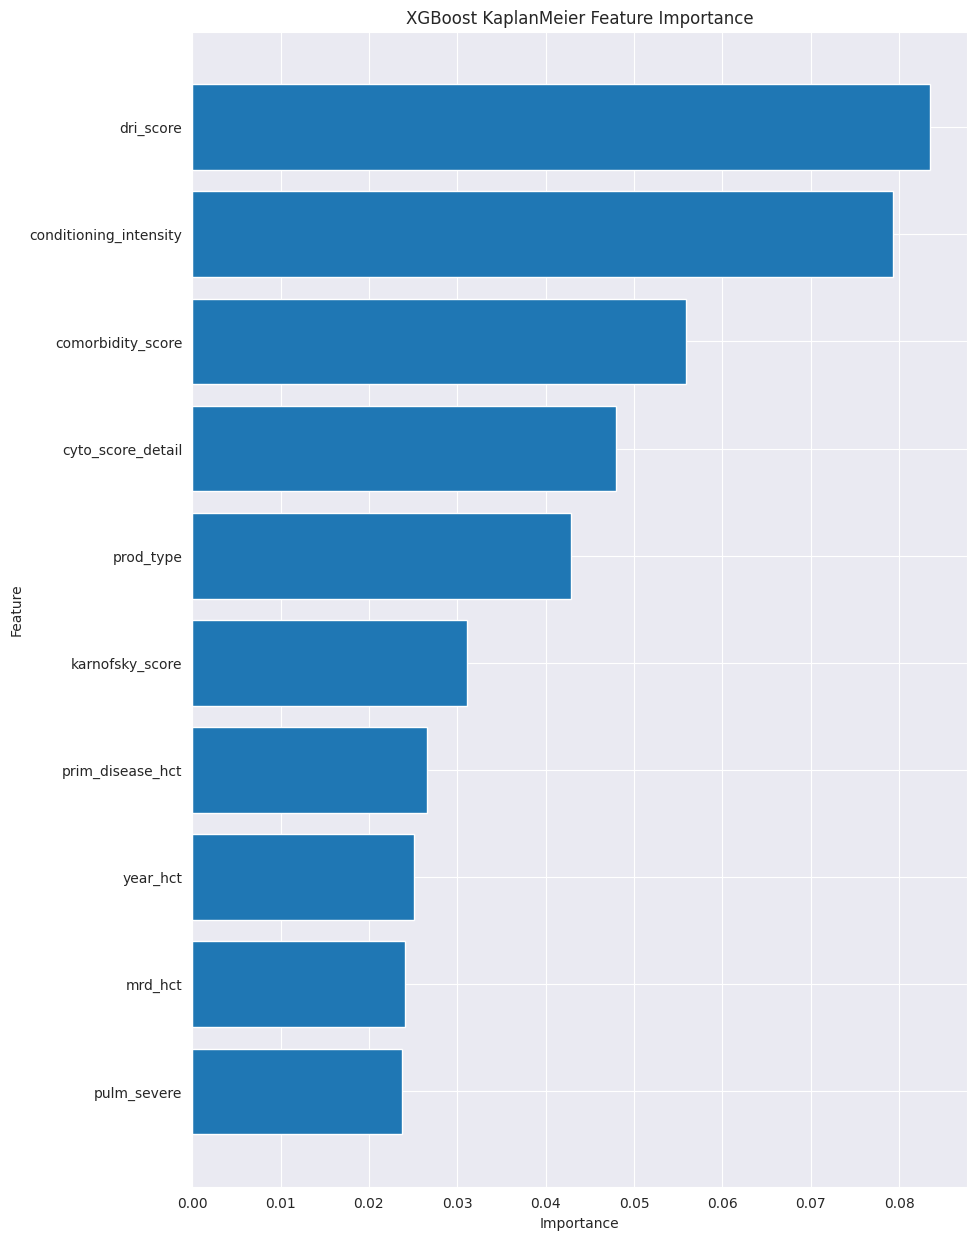

In [17]:
# feature_importance = model_xgb.feature_importances_
# importance_df = pd.DataFrame({
#     "Feature": features, 
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False).head(10)
# plt.figure(figsize=(10, 15))
# plt.barh(importance_df["Feature"], importance_df["Importance"])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("XGBoost KaplanMeier Feature Importance")
# plt.gca().invert_yaxis()  # Flip features for better readability
# plt.show()

# 3. XGBoost with Survival:Cox


In [18]:
# SURVIVAL COX NEEDS THIS TARGET (TO DIGEST EFS AND EFS_TIME)
train["efs_time2"] = train.efs_time.copy()
train.loc[train.efs==0,"efs_time2"] *= -1

In [19]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=99)
    
oof_xgb_cox = np.zeros(len(train))
pred_xgb_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,features].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,features].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[features].copy()

    model_xgb_cox = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        early_stopping_rounds=7,
        objective='survival:cox',
        eval_metric='cox-nloglik',
    )
    model_xgb_cox.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500  
    )
    
    # INFER OOF
    oof_xgb_cox[test_index] = model_xgb_cox.predict(x_valid)
    # INFER TEST
    pred_xgb_cox += model_xgb_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb_cox /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-cox-nloglik:8.31810
[500]	validation_0-cox-nloglik:8.14120
[647]	validation_0-cox-nloglik:8.13723
#########################
### Fold 2
#########################
[0]	validation_0-cox-nloglik:8.31276
[500]	validation_0-cox-nloglik:8.11665
[1000]	validation_0-cox-nloglik:8.10097
[1158]	validation_0-cox-nloglik:8.09876
#########################
### Fold 3
#########################
[0]	validation_0-cox-nloglik:8.30908
[500]	validation_0-cox-nloglik:8.11215
[1000]	validation_0-cox-nloglik:8.09826
[1088]	validation_0-cox-nloglik:8.09697
#########################
### Fold 4
#########################
[0]	validation_0-cox-nloglik:8.31351
[500]	validation_0-cox-nloglik:8.11830
[1000]	validation_0-cox-nloglik:8.10338
[1411]	validation_0-cox-nloglik:8.09806
#########################
### Fold 5
#########################
[0]	validation_0-cox-nloglik:8.30048
[500]	validation_0-cox-nloglik:8.10717
[895]	validation_0-cox-nlo

## 3.1 Score

In [20]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost Survival:Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost Survival:Cox = 0.6681405960316258


## 3.2 Features

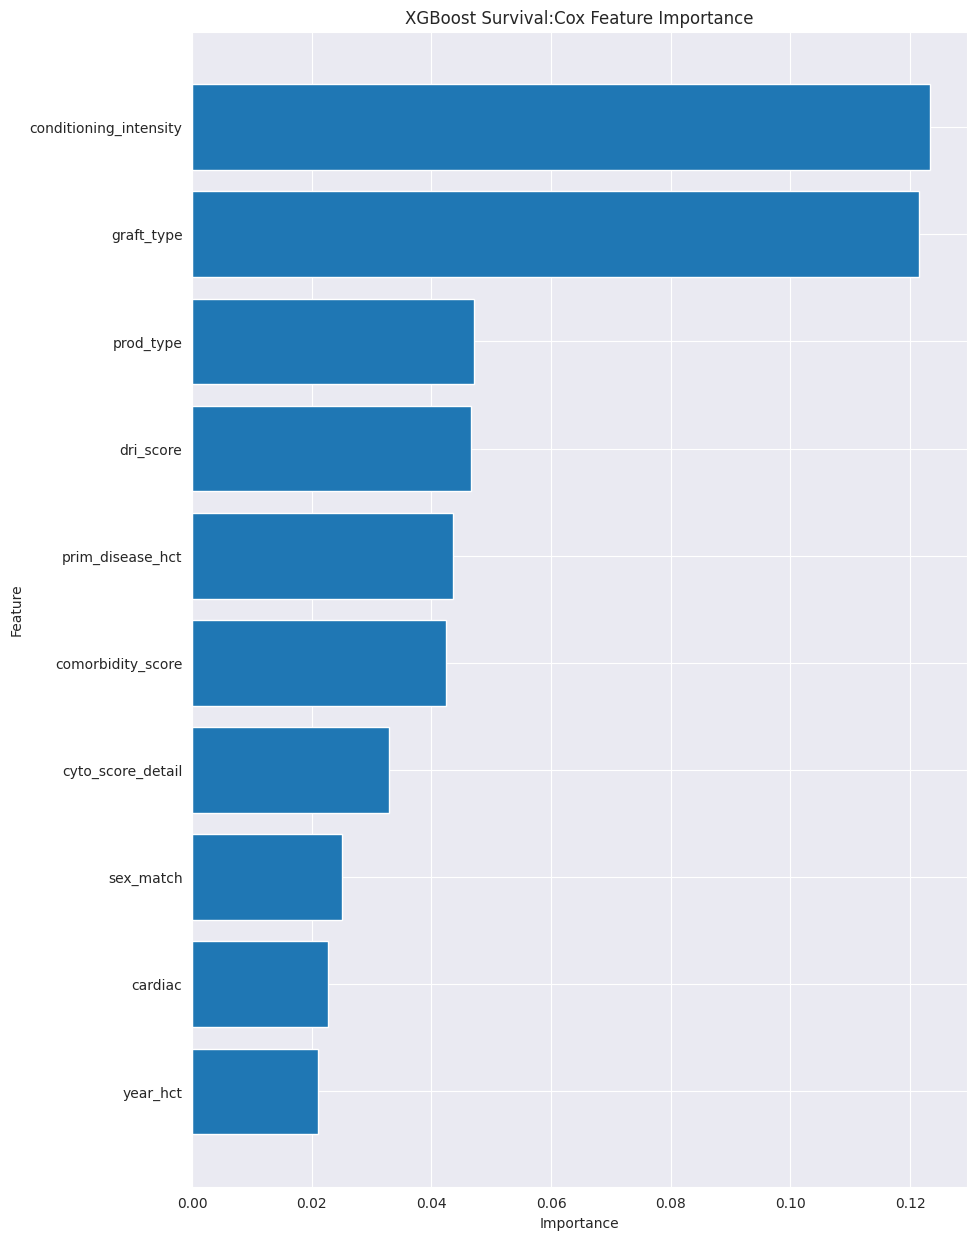

In [21]:
# feature_importance = model_xgb_cox.feature_importances_
# importance_df = pd.DataFrame({
#     "Feature": features,  # Replace FEATURES with your list of feature names
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False).head(10)
# plt.figure(figsize=(10, 15))
# plt.barh(importance_df["Feature"], importance_df["Importance"])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("XGBoost Survival:Cox Feature Importance")
# plt.gca().invert_yaxis()  # Flip features for better readability
# plt.show()

# 4. CatBoost with KaplanMeier

In [22]:
print("Using CatBoost version",cb.__version__)

Using CatBoost version 1.2.7


In [23]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=99)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,features].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,features].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[features].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
        learning_rate=0.1,    
        grow_policy='Lossguide',
        early_stopping_rounds=7,
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=250)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
0:	learn: 0.1747024	test: 0.1739987	best: 0.1739987 (0)	total: 98.9ms	remaining: 1m 38s
bestTest = 0.1583178948
bestIteration = 143
Shrink model to first 144 iterations.
#########################
### Fold 2
#########################
0:	learn: 0.1745917	test: 0.1753057	best: 0.1753057 (0)	total: 20.5ms	remaining: 20.5s
250:	learn: 0.1437392	test: 0.1564026	best: 0.1563767 (247)	total: 4.08s	remaining: 12.2s
bestTest = 0.1563708537
bestIteration = 255
Shrink model to first 256 iterations.
#########################
### Fold 3
#########################
0:	learn: 0.1745316	test: 0.1750436	best: 0.1750436 (0)	total: 20.2ms	remaining: 20.2s
250:	learn: 0.1440480	test: 0.1571163	best: 0.1571063 (245)	total: 5.27s	remaining: 15.7s
bestTest = 0.1565399616
bestIteration = 328
Shrink model to first 329 iterations.
#########################
### Fold 4
#########################
0:	learn: 0.1750013	test: 0.1728954	best: 0.1728954 (0)	tota

## 4.1 Score

In [24]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost KaplanMeier =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost KaplanMeier = 0.669698339062826


## 4.2 Features

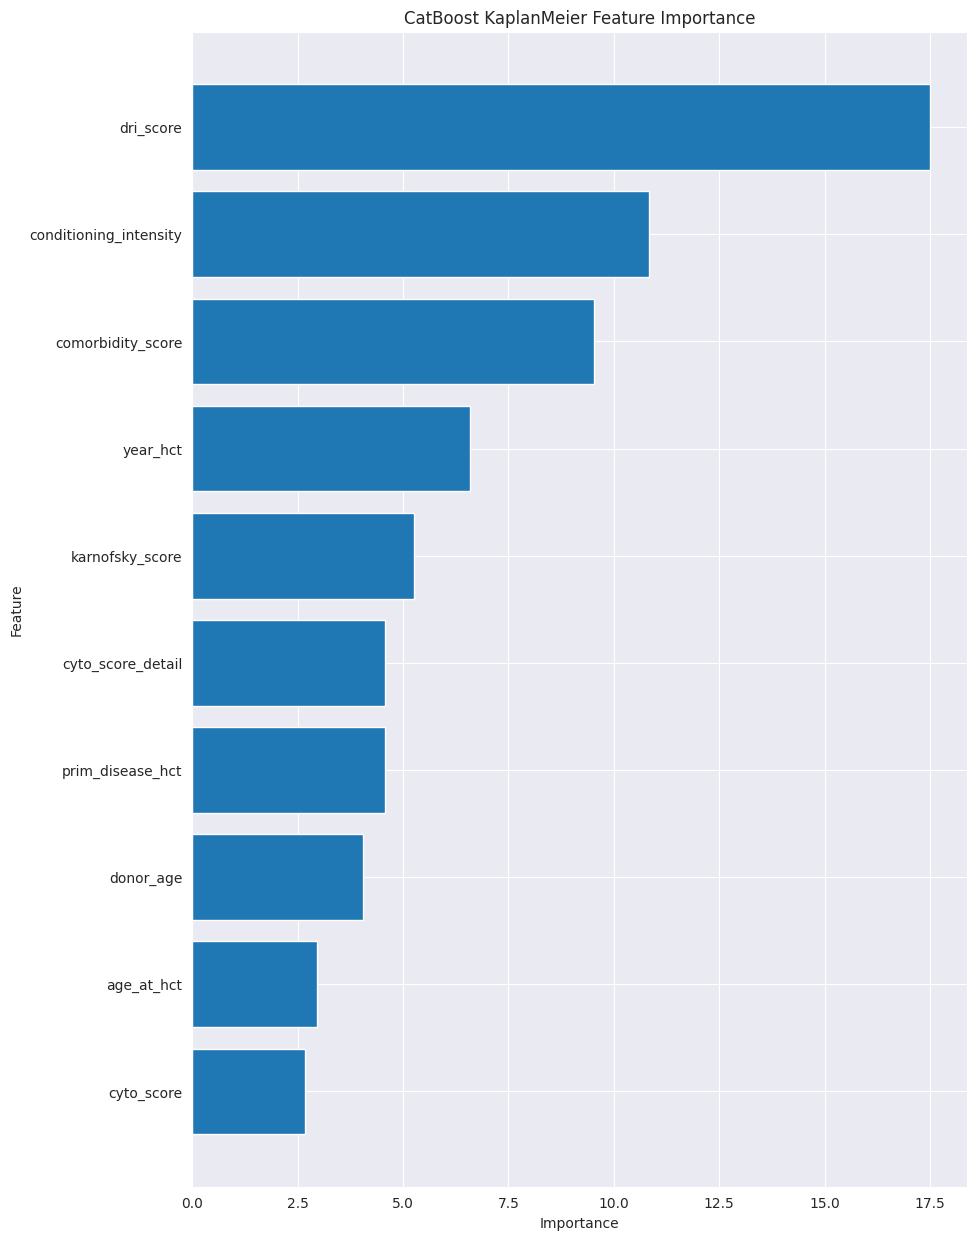

In [25]:
# feature_importance = model_cat.get_feature_importance()
# importance_df = pd.DataFrame({
#     "Feature": features, 
#     "Importance": feature_importance
# }).sort_values(by="Importance", ascending=False).head(10)
# plt.figure(figsize=(10, 15))
# plt.barh(importance_df["Feature"], importance_df["Importance"])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("CatBoost KaplanMeier Feature Importance")
# plt.gca().invert_yaxis()  # Flip features for better readability
# plt.show()

# 5. CatBoost with Survival:Cox

In [26]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=99)
    
oof_cat_cox = np.zeros(len(train))
pred_cat_cox = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,features].copy()
    y_train = train.loc[train_index,"efs_time2"]    
    x_valid = train.loc[test_index,features].copy()
    y_valid = train.loc[test_index,"efs_time2"]
    x_test = test[features].copy()

    model_cat_cox = CatBoostRegressor(
        loss_function="Cox",
        #task_type="GPU",   
        iterations=400,     
        learning_rate=0.1,  
        grow_policy='Lossguide',
        use_best_model=False,
        early_stopping_rounds=7,
    )
    model_cat_cox.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)
    
    # INFER OOF
    oof_cat_cox[test_index] = model_cat_cox.predict(x_valid)
    # INFER TEST
    pred_cat_cox += model_cat_cox.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat_cox /= FOLDS

#########################
### Fold 1
#########################
0:	learn: -120797.4990882	test: -25348.3079282	best: -25348.3079282 (0)	total: 65.6ms	remaining: 26.2s
100:	learn: -118005.0799259	test: -24843.2800597	best: -24843.2800597 (100)	total: 5.37s	remaining: 15.9s
Stopped by overfitting detector  (7 iterations wait)

bestTest = -24830.70098
bestIteration = 121

#########################
### Fold 2
#########################
0:	learn: -120482.1152147	test: -25615.7893453	best: -25615.7893453 (0)	total: 60.4ms	remaining: 24.1s
100:	learn: -117802.7492304	test: -25067.8690897	best: -25067.8690897 (100)	total: 5.32s	remaining: 15.7s
Stopped by overfitting detector  (7 iterations wait)

bestTest = -25040.1435
bestIteration = 155

#########################
### Fold 3
#########################
0:	learn: -120091.4249479	test: -25943.1150854	best: -25943.1150854 (0)	total: 60.9ms	remaining: 24.3s
100:	learn: -117436.5791906	test: -25392.2973708	best: -25392.2973708 (100)	total: 5.75s	rema

## 5.1 Score

In [31]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat_cox
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost Survival:Cox =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost Survival:Cox = 0.6649009608173863


## 5.2 Features

# 6. Ensemble

In [40]:
oof_cat, rankdata(oof_cat)

(array([0.49187179, 0.65227136, 0.47086055, ..., 0.71330356, 0.57828778,
        0.49507001]),
 array([ 1101., 21794.,   287., ..., 26096., 11346.,  1291.]))

In [42]:
from scipy.stats import rankdata 

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_xgb) +  rankdata(oof_xgb_cox)+ rankdata(oof_cat) + rankdata(oof_cat_cox)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6703688273275004


In [46]:
len(oof_xgb),len(y_true["efs_time"])

(28800, 28800)

In [52]:
compare = pd.DataFrame()
compare["Original"] = y_true["efs_time"]
compare["XGB KM"] = oof_xgb
compare["XGB SC"] = oof_xgb_cox
compare["CAT KM"] = oof_cat
compare["CAT SC"] = oof_cat_cox
compare.head(10)

,Original,XGB KM,XGB SC,CAT KM,CAT SC
0,42.356,0.493140,0.222782,0.491872,-1.415563
1,4.672,0.597159,1.186222,0.652271,0.318103
2,19.793,0.433435,0.134247,0.470861,-1.862530
3,102.349,0.661535,1.539969,0.663279,0.351315
4,16.223,0.625878,0.912648,0.635643,-0.024326
5,7.095,0.672240,1.636434,0.676872,0.377729
6,46.464,0.603711,1.466634,0.636541,0.385619
7,18.076,0.529586,0.250272,0.537741,-1.201521
8,10.130,0.598978,1.316321,0.592610,0.308812
9,5.434,0.579500,0.778098,0.555896,-0.350274


# 5. Submission CSV

In [56]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb) + rankdata(pred_xgb_cox) + rankdata(pred_cat) + rankdata(pred_cat_cox)
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,8.0
1,28801,12.0
2,28802,4.0
